### Influential people's tweets impact on people's thoughts

##### The idea of this part of project is to explore how influential people (politicians, journalists, singers, actors, etc.) from different countries used tweeter during the coronavirus pandemic. To see the correlation between their tweets and the tweets of normal daily Twitter users and Wikipedia users we will use the results of the analysis done in the first part of the project.

<br/>

In [524]:
import pandas as pd
import numpy as np

import re
import json
import string
from datetime import datetime, timedelta

import translators as ts

# Natural language processing libraries
import nltk
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer

# Twitter library
import tweepy

#Data visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

<br/>
We are using intervention data (from the given dataset coronawiki) and WHO dataset with number of new cases and deaths each day during pandemic in order to define periods of interest to analyse tweets for each country.

In [525]:
# Importing intervention dates for each country
data_path = './data/'

interventions = pd.read_csv(data_path + 'interventions.csv', delimiter=',', 
                            parse_dates=['1st case','1st death','School closure',
                                         'Public events banned','Lockdown','Mobility','Normalcy'])

interventions.set_index('lang', inplace = True)
interventions.head()

,1st case,1st death,School closure,Public events banned,Lockdown,Mobility,Normalcy
lang,,,,,,,
fr,2020-01-24,2020-02-14,2020-03-14,2020-03-13,2020-03-17,2020-03-16,2020-07-02
da,2020-02-27,2020-03-12,2020-03-13,2020-03-12,2020-03-18,2020-03-11,2020-06-05
de,2020-01-27,2020-03-09,2020-03-14,2020-03-22,2020-03-22,2020-03-16,2020-07-10
it,2020-01-31,2020-02-22,2020-03-05,2020-03-09,2020-03-11,2020-03-11,2020-06-26
nl,2020-02-27,2020-03-06,2020-03-11,2020-03-24,NaT,2020-03-16,2020-05-29


In [526]:
who_data = pd.read_csv(data_path + 'WHO-COVID-19-global-data.csv', delimiter=',')

who_data.set_index('Date_reported', inplace = True)
who_data.head()

,Country_code,Country,WHO_region,New_cases,Cumulative_cases,New_deaths,Cumulative_deaths
Date_reported,,,,,,,
2020-01-03,AF,Afghanistan,EMRO,0,0,0,0
2020-01-04,AF,Afghanistan,EMRO,0,0,0,0
2020-01-05,AF,Afghanistan,EMRO,0,0,0,0
2020-01-06,AF,Afghanistan,EMRO,0,0,0,0
2020-01-07,AF,Afghanistan,EMRO,0,0,0,0


We are loading dataset which provides us with dates and the number of clicks on wikipedia pages (from mobile phones and computers) of different topics during pandemic.

In [528]:
# Importing pagelogs time series
data_path = './data/'
with open(data_path+'aggregated_timeseries.json','r') as file:
    pagelogs_time_series = json.load(file)
    
pagelogs_time_series.keys()

dict_keys(['ja.m', 'it', 'da.m', 'tr', 'no.m', 'en', 'sr', 'tr.m', 'en.m', 'no', 'sv', 'nl.m', 'nl', 'da', 'de', 'fr.m', 'ca.m', 'de.m', 'ko.m', 'fi.m', 'sr.m', 'ja', 'fr', 'fi', 'ca', 'it.m', 'sv.m', 'ko'])

<br/>
We are starting our analysis by defining lists containing the names of the analysed countries and the spoken languages in those contries. We will focus on Europian countires from the given dataset.

In [15]:
# List of countires and langugeges spoken in this countries
countries = ['FR','DK','DE','IT','NL','NO','SE','RS','FI','GB']
languages = ['fr','da','de','it','nl','no','sv','sr','fi','en']

<br/>
For the first stage, we will focus on retrieving tweets of influential people from Serbia and Italy (our homelands) for the easier verification of the results.

In [530]:
# List of Twitter accounts of influental people from different countries
serbian_influential_people = ['avucic', 'SerbianPM', 'DraganDjilas', 'MarinikaTepic', 'JugoslavCosic',
                              'futomaki', 'VladoGeorgiev', 'brankica_st', 'OAmidzic']

italian_influential_people = ['matteorenzi', 'matteosalvinimi', 'GiorgiaMeloni', 'GiuseppeConteIT',
                              'Corriere', 'SkyTG24', 'LauraPausini', 'ValeYellow46', 'lorenzojova', 'Pontifex_it']

In [531]:
# reading bearer tokens which we need to access Twitter API
with open(data_path+'BearerTokens.json','r') as file:
    bearer_tokens = json.load(file)

In [537]:
def getTwitterUsers(client, usernames):
    """
    Function which retrieving users from 
    Twitter based on usernames
    
    Arguments:
        client : Twitter API v2 Client
        usernames : list of account usernames
    
    Returns:
        users: list of users - id, name, username
    """
    
    users = []
    for username in usernames:
        users.append(client.get_user(username=username))
    return users

In [538]:
# defining client which enables connection with Twitter API
client = tweepy.Client(bearer_token=bearer_tokens["maja"], wait_on_rate_limit=True)

# getting users accounts from twitter
serbian_users = getTwitterUsers(client, serbian_influential_people)
italian_users = getTwitterUsers(client, italian_influential_people)

for user in serbian_users: print(user.data.id, user.data.name, user.data.username)

356450858 Александар Вучић avucic
3036495555 Aна Брнабић SerbianPM
205153283 Dragan Djilas DraganDjilas
834073582514888710 Marinika Tepić MarinikaTepic
2814717661 Jugoslav Ćosić JugoslavCosic
181338564 Marija Serifovic futomaki
41577631 Vlado Georgiev - Barba VladoGeorgiev
1087237020 Brankica Stankovic brankica_st
324198256 ognjen amidzic OAmidzic


<br/>
We want to retrieve tweets from different periods during pandemic, but mostly focusing on weeks preceding intervention days or period with peeks in number of new cases and people's deaths. As an example, we are starting with period three weeks before lockdown in each country.

In [540]:
# Defining period of interest for each country. Dates refered to 3 weeks before the first lockdown
lockdown_dates =  [interventions.loc[lang, 'Lockdown'] for lang in languages]

period_per_countries = {}
for idx,country in enumerate(countries):
    lang = languages[idx]
    dates = [datetime.strptime(date.split()[0], '%Y-%m-%d')  for date in list(pagelogs_time_series[lang]['sum'].keys())]
    dates = [date for date in dates if (lockdown_dates[idx] - date < timedelta(21)) and 
             (lockdown_dates[idx] - date >  timedelta(0))]
    period_per_countries[country] = dates
    
# e.g. three weeks before lockdown in Serbia and Italy
print('Serbia',period_per_countries['RS'][0],'-',period_per_countries['RS'][-1])
print('Italy',period_per_countries['IT'][0],'-',period_per_countries['IT'][-1])

Serbia 2020-03-01 00:00:00 - 2020-03-20 00:00:00
Italy 2020-02-20 00:00:00 - 2020-03-10 00:00:00


<br/>
Now, we want to create dataframe which will contain tweets from influential people from different countries. Each row will contain tweet id, country and languge of tweet, id of user which posted that tweet, orginal text of tweet and its translation to english, date when tweeet is posted and context annotation retrieved from Twitter API.

In [301]:
# Create empty dataframe (executed once)
df = pd.DataFrame(columns=['id','country_code', 'lang', 'user', 'tweet_text_orginal', 
                           'tweet_text_en', 'tweet_date', 'context_annotations'])

df.to_csv('influential_people_tweets_new.csv', index=False)

In [541]:
def remove_emojis(data):
    """
    Function which removing emojis from tweet's text
    
    Arguments:
        data : tweet text
    
    Returns:
        text: text without emojis
    """
    
    emoj = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                      "]+", re.UNICODE)
    return re.sub(emoj, '', data)

In [303]:
def update_influental_people_dataframe(client, country_code, lang, users, dates):
    """
    Function which retrieving new tweets using Twitter API
    
    Arguments:
        client : Twitter API v2 Client
        country_code: country from which we are retrieving tweets
        lang: languge of tweets we are retrieving
        users: list of users which tweets we want to retrieve
        dates: list of dates for which we want to retrieve tweets
    
    Returns:
        influential_people_tweets: dataframe containing tweets which 
        satisfying conditions sent as parameters of function
    """
        
    start_time = dates[country_code][0]
    end_time = dates[country_code][-1] 
    
    influential_people_tweets = pd.read_csv('influential_people_tweets.csv', delimiter=',')
    
    for user in users:
        # We define a proper query to get tweets from the country we're interested in
        query = "from:{} -is:retweet".format(user.data.id)
                
        tweets = client.search_all_tweets(query, max_results=100, 
                                      start_time=start_time, end_time=end_time,
                                      tweet_fields=['id','text','context_annotations','created_at'])
        
        if(tweets.data == None): continue
        
        for tweet in tweets.data: 
            tweet_en = tweet.text
            
            #translating tweet to english
            if lang != 'en':
                try:
                    tweet_en = ts.google(tweet.text)
                except:
                    tweet_en = None
                    
            if tweet_en != None:
                # removing punctuation
                tweet_en = ("".join([ch for ch in tweet_en if ch not in '!"$%&\'()*+,-./:;<=>?[\\]^_`{|}~'])).lower()
                tweet_en.strip()
                # removing numbers
                tweet_en = re.sub("\d+", "", tweet_en).strip()
                
            # merging hashtag sign with next word 
            if('# ' in tweet_en):
                tweet_en.replace('# ', '#')
        
            # removing emojis
            tweet_en = remove_emojis(tweet_en)
            
            # removing username tags and http links
            if('http' in tweet_en) or ('@' in tweet_en):
                tweet_en = " ".join(filter(lambda word: (not word.startswith('http')) and (not word.startswith('@')),
                                           tweet_en.split()))

            new_tweet = pd.DataFrame([{'id': tweet.id, 'country_code': country_code, 'lang': lang, 'user': user,
                                       'tweet_text_orginal': tweet.text, 'tweet_text_en': tweet_en, 
                                       'tweet_date': tweet.created_at,
                                       'context_annotations': tweet.context_annotations }])
            
            influential_people_tweets = pd.concat([influential_people_tweets, new_tweet], axis=0, ignore_index=True)
        
    
    return influential_people_tweets

<br/>
Let's load existing tweets and merge dataset with new ones.

In [694]:
# load tweets for csv file
influential_people_tweets = pd.read_csv('influential_people_tweets.csv', delimiter=',')
influential_people_tweets.head()

,Unnamed: 0,id,country_code,lang,user,tweet_text_orginal,tweet_text_en,tweet_date,context_annotations
0,0,1240013952861511680,RS,sr,Response(data=<User id=356450858 name=Александ...,Поносни смо на наше пријатељство.\r\nНикада не...,we are proud of our friendship we will never f...,2020-03-17 20:35:39+00:00,[]
1,1,1239873649999523845,RS,sr,Response(data=<User id=356450858 name=Александ...,Бескрајно хвала на свему нашој кинеској браћи ...,infinitely thank you for all our chinese broth...,2020-03-17 11:18:08+00:00,"[{'domain': {'id': '123', 'name': 'Ongoing New..."
2,2,1239310408760074240,RS,sr,Response(data=<User id=356450858 name=Александ...,"Предаја није, никада није била и никада неће б...",the surrender is not it was never and will nev...,2020-03-15 22:00:01+00:00,[]
3,3,1238813645385187328,RS,sr,Response(data=<User id=356450858 name=Александ...,"Pадимо, боримо се и урадићемо све што треба. С...",we fall we fight and we will do whatever you n...,2020-03-14 13:06:03+00:00,[]
4,4,1237796648161599491,RS,sr,Response(data=<User id=356450858 name=Александ...,"Одлуке доноси струка, не политика.\r\nХвала на...",decisions make a profession not politics thank...,2020-03-11 17:44:52+00:00,[]


In [305]:
# retrieving tweets (delete the dot from line below to execute)
.
influential_people_tweets_update = update_influental_people_dataframe(client, 'IT', 'it', italian_users,  period_per_countries)
influential_people_tweets = pd.concat([influential_people_tweets, influential_people_tweets_update], ignore_index=True)
influential_people_tweets.to_csv('influential_people_tweets.csv')

<br/>
For each country we would like to recognise to which topics tweets are related, what are most common used words in tweets and to check sentyment of the tweets. All of this can be useful to understand the way communication has changed during the pandemic and impacted people.


In [543]:
# Libray to infer the topics discussed in each tweet
from empath import Empath
lexicon = Empath()


After reading the categories offered by empath library at https://github.com/Ejhfast/empath-client/blob/master/empath/data/categories.tsv, we report the ones we decide to use.

In [542]:
topics = ['help','medical_emergency','health','government','school','kill','art','play','computer',
         'home','business','religion','sports','death','military','music','science','fun','economics',
         'technology','philosophy','geography','tv','architecture']

emotions = ["suffering","optimism","fear","sadness","joy","anger","pain","negative_emotion","positive_emotion",
           "happiness"]

Using Empath library we want to check to which topics tweets from period three weeks before lockdown are mostly related. We will plot result to two countries, Serbia and Italy.

In [735]:
# function for plotting topic discussed in tweets
def plotTweetsTopics(country_code, country_name, topics, influential_people_tweets):
    """
    Function which plots topic discussed in tweets
    
    Arguments:
        country_code: code of country from which we are retrieving tweets
        country_name: name of country from which we are retrieving tweets
        topics: list of topics
        influential_people_tweets: dataframe with tweets
    """
    
    # We infer the topics discussed in the retrieved tweets
    tweets_from_country = influential_people_tweets.loc[influential_people_tweets['country_code']==country_code, 
                                                        'tweet_text_en']
     # plot only if we have some data from country
    if len(tweets_from_country) > 0:
        classified_topics = pd.DataFrame([lexicon.analyze(tweets_from_country.str.cat(sep = ' '),
                                                      categories = topics, 
                                                      normalize = True)], index = [country_code]).T

        classified_topics = classified_topics.sort_values(by = [country_code], ascending = False)
        classified_topics.reset_index(inplace = True)
        
        fig,ax = plt.subplots(1)

        sns.barplot(data = classified_topics, x = country_code, y = 'index')

        plt.xlabel('Normalized Score')
        plt.ylabel('Topics', fontsize = 14)
        plt.title('Topics discussed in ' + country_name + ' during the 3 weeks preceding the official lockdown')
        plt.show()

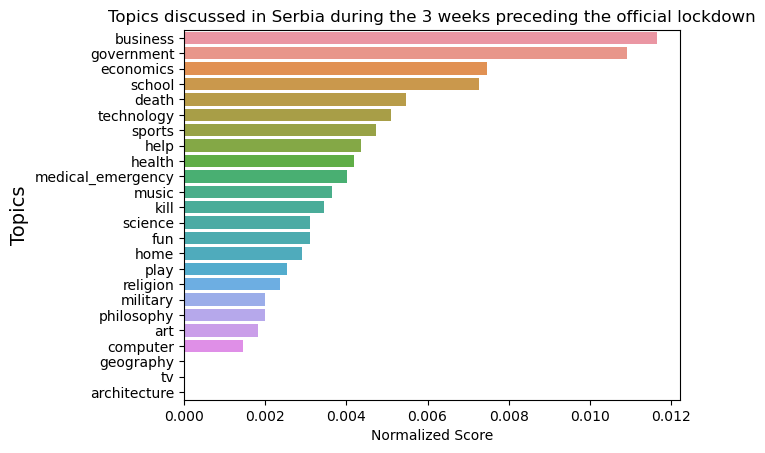

In [736]:
# plotting topic discussed in Serbia and Italy 3 weeks precedign the lockdown
plotTweetsTopics('RS', 'Serbia', topics, influential_people_tweets)
plotTweetsTopics('IT', 'Italy', topics, influential_people_tweets)

Using Empath library we want to check to which topics tweets from period three weeks before lockdown are mostly related. We will plot result to two countries, Serbia and Italy.

In [737]:
# function for plotting dominating emotions in tweets 
def plotTweetsEmotions(country_code, country_name, emotions, influential_people_tweets):
    """
    Function which plots dominating emotions in tweets
    
    Arguments:
        country_code: code of country from which we are retrieving tweets
        country_name: name of country from which we are retrieving tweets
        emotions: list of topics
        influential_people_tweets: dataframe with tweets
    """
    tweets_from_country = influential_people_tweets.loc[influential_people_tweets['country_code']==country_code, 
                                                        'tweet_text_en']
    if len(tweets_from_country) > 0:
        # We infer the topics discussed in the retrieved tweets
        classified_emotions = pd.DataFrame([lexicon.analyze(tweets_from_country.str.cat(sep = ' '),
                                                            categories = emotions, 
                                                            normalize = True)], index = [country_code]).T

        classified_emotions = classified_emotions.sort_values(by = [country_code], ascending = False)
        classified_emotions.reset_index(inplace = True)
        
        fig,ax = plt.subplots(1)

        sns.barplot(data = classified_emotions, x = country_code, y = 'index')

        plt.xlabel('Normalized Score', fontsize = 12)
        plt.ylabel('Emotions', fontsize = 12)
        plt.title('Dominating emotions in tweets posted in ' + country_name + 
                  ' during the 3 weeks preceding the official lockdown')
        plt.show()

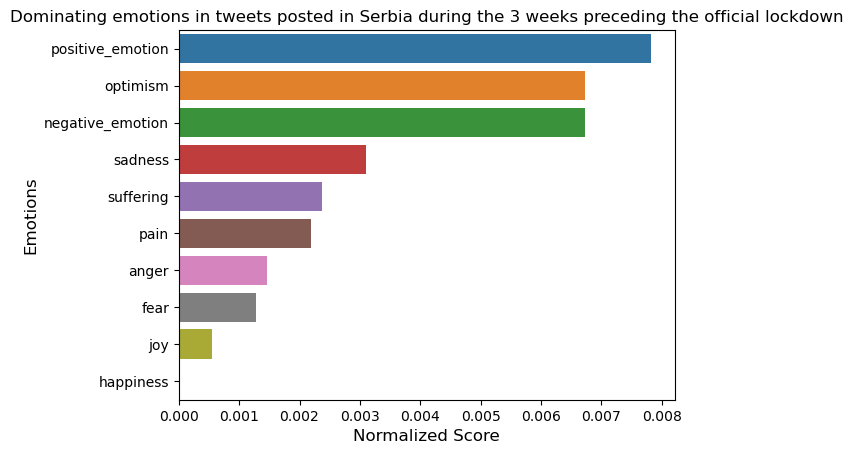

In [738]:
# plotting dominating emotions in tweets in Serbia and Italy 3 weeks precedign the lockdown
plotTweetsEmotions('RS', 'Serbia', emotions, influential_people_tweets)
plotTweetsEmotions('IT', 'Italy', emotions, influential_people_tweets)

As next step in our analysis, we want to find most used words in tweets in different countries. As an example we are plotting most used words in tweets of Serbian and Italian influencing Twitter users.

In [673]:
from collections import Counter

def plotMostCommonWords(country_code, country_name, influential_people_tweets):
    """
    Function which plot most common words in tweets of country
    
    Arguments:
        country_code: code of country from which we are retrieving tweets
        country_name: name of country from which we are retrieving tweets
        influential_people_tweets: dataframe with tweets
    Returns:
        most_common_words: list of most common words in tweeets
        all_words: all words from the tweets
    """
    
    # spliting text on words removing stop words, and looking only to nouns and verbs
    lemmatizer = WordNetLemmatizer()
    tweets_from_country = influential_people_tweets.loc[influential_people_tweets['country_code']==country_code, 
                                                        'tweet_text_en']
    all_words = ("".join(tweets_from_country.str.cat(sep = ' '))).split()
    all_words = [lemmatizer.lemmatize(term) for term in all_words 
                 if (term not in stopwords.words('english')) and 
                 (nltk.pos_tag([term])[0][1] == 'NN' or nltk.pos_tag([term])[0][1] == 'VB')]

    # ten most common words
    most_common_words = Counter(all_words).most_common(10)

    words = list(dict(most_common_words).keys())
    counts = list(dict(most_common_words).values())

    plt.xlabel('Most used words', fontsize = 12)
    plt.ylabel('Count', fontsize = 12)
    plt.title('Most used words in influencing people tweets from '+ country_name)
    plt.bar(range(len(words)), counts, tick_label=words)
    plt.show()
    
    return most_common_words, all_words

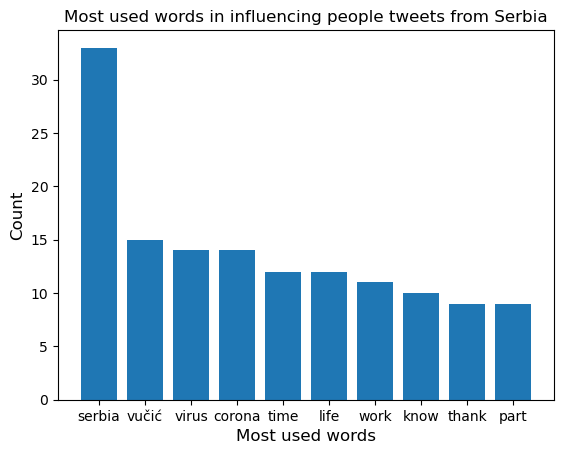

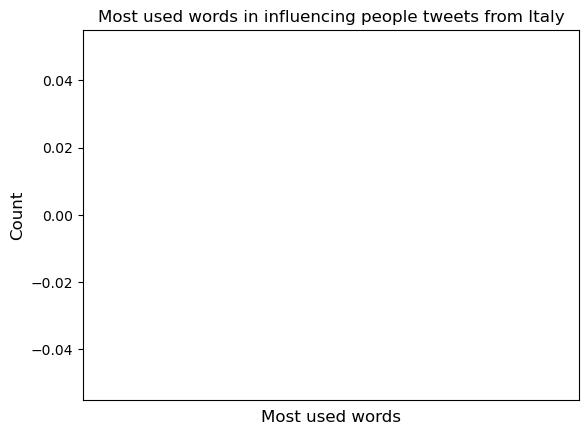

In [674]:
# plotting most common words in Serbian and Italian tweets
most_common_words_sr, all_words_sr = plotMostCommonWords('RS', 'Serbia', influential_people_tweets)
most_common_words_it, all_words_it = plotMostCommonWords('IT', 'Italy', influential_people_tweets)

Similarly, let us find most used hashtags in tweets in different countries. As an example we are plotting most used hashtags in tweets of Serbian and Italian influencing Twitter users.

In [678]:
def plotMostCommonHashtags(country_name, all_words):
    """
    Function which plot most common hashtags in tweets of country
    
    Arguments:
        country_code: code of country from which we are retrieving tweets
        country_name: name of country from which we are retrieving tweets
        influential_people_tweets: dataframe with tweets
    Returns:
        most_common_hashtags: list of most common words in tweeets
    """
    #finding most common hashtags
    hashtags = [word for word in all_words if ('#' in word)]
    most_common_hashtags = Counter(hashtags).most_common(10)

    hashtags = list(dict(most_common_hashtags).keys())
    counts = list(dict(most_common_hashtags).values())

    plt.xlabel('Most used hashtags', fontsize = 12)
    plt.ylabel('Count', fontsize = 12)
    plt.xticks(rotation = 90)
    plt.title('Most used hashtags in influencing people tweets from ' + country_name)
    plt.bar(range(len(hashtags)), counts, tick_label=hashtags)
    plt.show()
    
    return most_common_hashtags

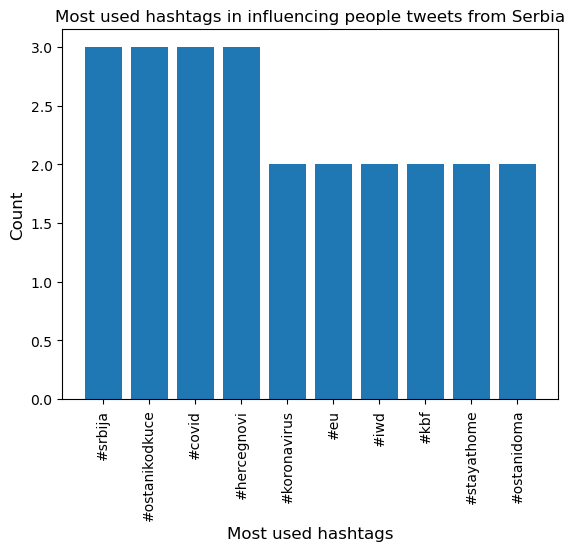

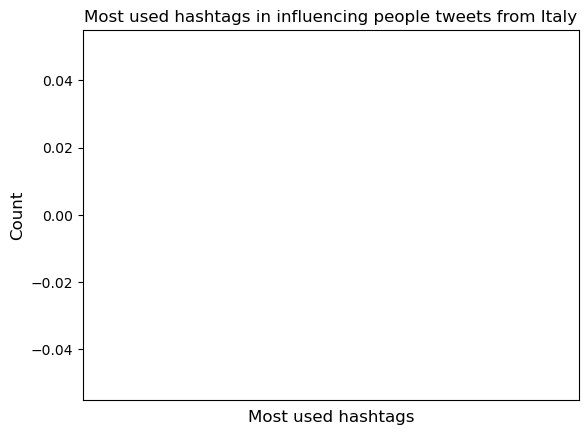

[]

In [679]:
# plotting most common hashtags in Serbia and Italy
plotMostCommonHashtags('Serbia', all_words_sr)
plotMostCommonHashtags('Italy', all_words_it)

Since hashtags are sometime composed from multiple words, and it is difficult to translate it using some libraries, we are doing it manually and plotting again. Again, we are doing this for Serbia and Italy as an example. 

In [680]:
most_common_hashtags_RS = { '#serbia': 3, '#stayathome': 7, '#covid': 3, 
                           '#hercegnovi': 3, '#coronavirus': 2, '#eu': 2,
                           '#iwd': 2, '#kbf': 2 }

In [684]:
from wordcloud import WordCloud
import warnings
warnings.filterwarnings('ignore')

def imgHashtags(hashtags):
    """
    Function which shows most common hashtags 
    
    Arguments:
        hashtags: dict of hashtags
    """
    wc = WordCloud(background_color='white').generate_from_frequencies(dict(hashtags))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()

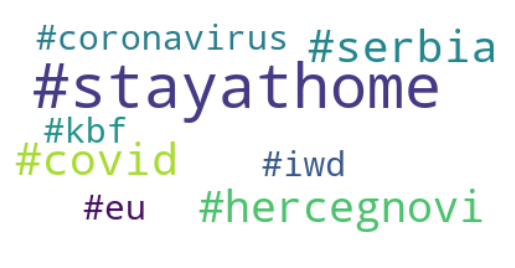

In [688]:
# show most common hashtags in Serbia and Italy in english
imgHashtags(most_common_hashtags_RS)

As last step in initial analysis of tweets of influencing people from different countries, we are difining function which calculate tweet sentiment ot give us more infomarion about tweets in one coutry.

In [573]:
# sentiment analysis using TextBlob
from textblob import TextBlob 

def tweetSentiment(data):
    text_sentiment = TextBlob(data).sentiment
    return text_sentiment.polarity, text_sentiment.subjectivity

In [692]:
for index, row in influential_people_tweets.iterrows():
    tweet = str(row['tweet_text_en'])
    polarity, subjectivity = tweetSentiment(tweet)   
    print(tweet, "==>", polarity, "-" ,subjectivity)
    break

we are proud of our friendship we will never forget the help of our chinese friends ==> 0.4 - 0.5


<br/>

#### Future steps

Here explanation what is finial goal with this data, same thing as in README.

<br/>
<br/>
<br/>
<br/>


#### test code -- to be deleted

In [472]:
for index, row in influential_people_tweets.iterrows():
    tweet_en = row['tweet_text_orginal']
    if row['lang'] != 'en':
        try:
            tweet_en = ts.google(tweet_en)
        except:
            tweet_en = None            

    if tweet_en != None:
        # We remove punctuation
        tweet_en = ("".join([ch for ch in tweet_en if ch not in '!"$%&()*+,-./:;<=>?[\\]^_`{|}~'])).lower()
        tweet_en.strip()
        # We remove numbers
        tweet_en = re.sub("\\d+", "", tweet_en).strip()
        
        
        if('# ' in tweet_en):
            tweet_en.replace('# ', '#')
        
        tweet_en = remove_emojis(tweet_en)
            
        if('http' in tweet_en) or ('@' in tweet_en):
            tweet_en = " ".join(filter(lambda word: (not word.startswith('http')) and (not word.startswith('@')),
                                       tweet_en.split()))

    influential_people_tweets.loc[influential_people_tweets['id'] == row['id'], 'tweet_text_en'] = tweet_en        
    
influential_people_tweets.to_csv('influential_people_tweets.csv', index=False)